## Baseline for classical models such as SVM and logistic regression

In [5]:
# Setup and Configuration

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from joblib import load
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load the dataset

# Load your Tox21 dataset
df = pd.read_csv("data/tox21.csv")  # Update this path if needed


In [3]:
# Filter for Valid SMILES
def is_valid_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return mol is not None and mol.GetNumAtoms() > 0

df = df[df['smiles'].apply(is_valid_smiles)].reset_index(drop=True)


[19:45:12] WARNING: not removing hydrogen atom without neighbors


In [4]:
# Featurize Molecus (Morgan Fingerprints)

morgan_gen = GetMorganGenerator(radius=2, fpSize=1024)

def smiles_to_ecfp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros((morgan_gen.GetNumBits(),))
    return np.array(morgan_gen.GetFingerprint(mol))

X = np.array([smiles_to_ecfp(s) for s in df['smiles']])


[19:45:43] WARNING: not removing hydrogen atom without neighbors


In [6]:
# Utility function for evaluation

def evaluate(name, target, y_true, y_prob, y_pred):
    """
    Calculate evaluation metrics for one model on one targt.
    """

    return {
        "Target": target,
        "Model": name,
        "ROC-AUC": roc_auc_score(y_true, y_prob),
        "PR-AUC": average_precision_score(y_true, y_prob),
        "F1-Score": f1_score(y_true, y_pred)
    }

In [7]:
# Tox21 targets
targets = ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER',
           'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5',
           'SR-HSE', 'SR-MMP', 'SR-p53']

# Store CV results
lr_cv_results = {}
svm_cv_results = {}

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for target in targets:
    print(f"\n📌 Processing target: {target}")
    
    y = df[target]
    mask = y.notna()
    X_clean = X[mask]
    y_clean = y[mask].values

    lr_aucs = []
    svm_aucs = []

    for train_idx, test_idx in skf.split(X_clean, y_clean):
        X_train, X_test = X_clean[train_idx], X_clean[test_idx]
        y_train, y_test = y_clean[train_idx], y_clean[test_idx]

        # Logistic Regression
        lr = LogisticRegression(max_iter=1000, class_weight='balanced')
        lr.fit(X_train, y_train)
        lr_proba = lr.predict_proba(X_test)[:, 1]
        lr_auc = roc_auc_score(y_test, lr_proba)
        lr_aucs.append(lr_auc)

        # Support Vector Machine
        svm = SVC(kernel='rbf', probability=True, class_weight='balanced')
        svm.fit(X_train, y_train)
        svm_proba = svm.predict_proba(X_test)[:, 1]
        svm_auc = roc_auc_score(y_test, svm_proba)
        svm_aucs.append(svm_auc)

    # Store mean AUCs
    lr_cv_results[target] = np.mean(lr_aucs)
    svm_cv_results[target] = np.mean(svm_aucs)

    print(f"✅ LR Mean ROC-AUC: {lr_cv_results[target]:.4f}")
    print(f"✅ SVM Mean ROC-AUC: {svm_cv_results[target]:.4f}")



📌 Processing target: NR-AR
✅ LR Mean ROC-AUC: 0.7365
✅ SVM Mean ROC-AUC: 0.7664

📌 Processing target: NR-AR-LBD
✅ LR Mean ROC-AUC: 0.8465
✅ SVM Mean ROC-AUC: 0.8813

📌 Processing target: NR-AhR
✅ LR Mean ROC-AUC: 0.8455
✅ SVM Mean ROC-AUC: 0.8959

📌 Processing target: NR-Aromatase
✅ LR Mean ROC-AUC: 0.7635
✅ SVM Mean ROC-AUC: 0.8262

📌 Processing target: NR-ER
✅ LR Mean ROC-AUC: 0.6786
✅ SVM Mean ROC-AUC: 0.7121

📌 Processing target: NR-ER-LBD
✅ LR Mean ROC-AUC: 0.7745
✅ SVM Mean ROC-AUC: 0.8045

📌 Processing target: NR-PPAR-gamma
✅ LR Mean ROC-AUC: 0.7574
✅ SVM Mean ROC-AUC: 0.7986

📌 Processing target: SR-ARE
✅ LR Mean ROC-AUC: 0.7351
✅ SVM Mean ROC-AUC: 0.8128

📌 Processing target: SR-ATAD5
✅ LR Mean ROC-AUC: 0.7829
✅ SVM Mean ROC-AUC: 0.8303

📌 Processing target: SR-HSE
✅ LR Mean ROC-AUC: 0.7055
✅ SVM Mean ROC-AUC: 0.7761

📌 Processing target: SR-MMP
✅ LR Mean ROC-AUC: 0.8338
✅ SVM Mean ROC-AUC: 0.8907

📌 Processing target: SR-p53
✅ LR Mean ROC-AUC: 0.7619
✅ SVM Mean ROC-AUC: 0.85

In [10]:
cv_df = pd.DataFrame({
    "Target": targets,
    "Logistic Regression (CV ROC-AUC)": [lr_cv_results[t] for t in targets],
    "SVM (CV ROC-AUC)": [svm_cv_results[t] for t in targets]
})

# Display the result
display(cv_df)

# Optional: Save results to CSV
cv_df.to_csv("logreg_svm_cv_beforeTuning_results.csv", index=False)


,Target,Logistic Regression (CV ROC-AUC),SVM (CV ROC-AUC)
0,NR-AR,0.736537,0.766402
1,NR-AR-LBD,0.846463,0.881294
2,NR-AhR,0.845488,0.895875
3,NR-Aromatase,0.763546,0.826168
4,NR-ER,0.678619,0.712114
5,NR-ER-LBD,0.774452,0.804503
6,NR-PPAR-gamma,0.757391,0.798628
7,SR-ARE,0.735086,0.812835
8,SR-ATAD5,0.782908,0.830309
9,SR-HSE,0.705534,0.776085


In [11]:
# Import for Tuning

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform

In [12]:
# Define Tuning Grids

# Hyperparameter distributions for tuning
lr_param_grid = {
    'C': loguniform(1e-3, 1e2),  # Regularization strength
    'penalty': ['l2'],
    'solver': ['lbfgs']  # Ensure it supports probability output
}

svm_param_grid = {
    'C': loguniform(1e-2, 1e2),
    'gamma': loguniform(1e-4, 1e0),
    'kernel': ['rbf']
}

In [13]:
# Tuning Logistic Regression and SVM

# Containers for results
best_lr_models = {}
lr_tuning_results = {}

best_svm_models = {}
svm_tuning_results = {}

# Loop through each target
for target in targets:
    print(f"\n🔍 Tuning Logistic Regression and SVM for: {target}")
    
    y = df[target]
    mask = y.notna()
    X_clean = X[mask]
    y_clean = y[mask].values

    if len(np.unique(y_clean)) < 2:
        print(f"⚠️ Skipping {target} (insufficient label diversity)")
        continue

    # Logistic Regression
    lr_base = LogisticRegression(max_iter=1000, class_weight='balanced')
    lr_search = RandomizedSearchCV(
        estimator=lr_base,
        param_distributions=lr_param_grid,
        n_iter=20,
        scoring='roc_auc',
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    lr_search.fit(X_clean, y_clean)
    lr_tuning_results[target] = lr_search.best_score_
    best_lr_models[target] = lr_search.best_estimator_
    print(f"✅ LR Best ROC-AUC: {lr_search.best_score_:.4f}")
    print(f"   Best Params: {lr_search.best_params_}")

    # SVM
    svm_base = SVC(probability=True, class_weight='balanced')
    svm_search = RandomizedSearchCV(
        estimator=svm_base,
        param_distributions=svm_param_grid,
        n_iter=20,
        scoring='roc_auc',
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    svm_search.fit(X_clean, y_clean)
    svm_tuning_results[target] = svm_search.best_score_
    best_svm_models[target] = svm_search.best_estimator_
    print(f"✅ SVM Best ROC-AUC: {svm_search.best_score_:.4f}")
    print(f"   Best Params: {svm_search.best_params_}")



🔍 Tuning Logistic Regression and SVM for: NR-AR
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ LR Best ROC-AUC: 0.7972
   Best Params: {'C': 0.008260808399079602, 'penalty': 'l2', 'solver': 'lbfgs'}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ SVM Best ROC-AUC: 0.8023
   Best Params: {'C': 0.16480446427978965, 'gamma': 0.012561043700013555, 'kernel': 'rbf'}

🔍 Tuning Logistic Regression and SVM for: NR-AR-LBD
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ LR Best ROC-AUC: 0.8517
   Best Params: {'C': 0.011526449540315611, 'penalty': 'l2', 'solver': 'lbfgs'}
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ SVM Best ROC-AUC: 0.8743
   Best Params: {'C': 2.5378155082656626, 'gamma': 0.06796578090758153, 'kernel': 'rbf'}

🔍 Tuning Logistic Regression and SVM for: NR-AhR
Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ LR Best ROC-AUC: 0.8803
   Best Params: {'C': 0.03320559103751957, 'penalty': 'l2', 'solve

In [14]:
import pandas as pd

# Compile Logistic Regression tuning results into a list of dictionaries
lr_results_list = []

for target in lr_tuning_results:
    best_model = best_lr_models[target]
    result = {
        "Target": target,
        "Model": "LogisticRegression",
        "Best ROC-AUC": lr_tuning_results[target]
    }
    result.update(best_model.get_params())  # Add hyperparams as columns
    lr_results_list.append(result)

# Create DataFrame
lr_results_df = pd.DataFrame(lr_results_list)

# Save to CSV
lr_results_df.to_csv("logistic_regression_tuning_results.csv", index=False)


In [15]:
# Compile SVM tuning results into a list of dictionaries
svm_results_list = []

for target in svm_tuning_results:
    best_model = best_svm_models[target]
    result = {
        "Target": target,
        "Model": "SVM",
        "Best ROC-AUC": svm_tuning_results[target]
    }
    result.update(best_model.get_params())  # Add hyperparams as columns
    svm_results_list.append(result)

# Create DataFrame
svm_results_df = pd.DataFrame(svm_results_list)

# Save to CSV
svm_results_df.to_csv("svm_tuning_results.csv", index=False)

In [17]:
combined_results_df = pd.concat([lr_results_df, svm_results_df], axis=0)
combined_results_df.to_csv("combined_tuning_classical_results.csv", index=False)

In [18]:
import os

output_dir = "final_classical_model"
os.makedirs(output_dir, exist_ok=True)


### Saving model

In [19]:
import joblib

# Save Logistic Regression models
for target, model in best_lr_models.items():
    filename = os.path.join(output_dir, f"lr_{target}.pkl")
    joblib.dump(model, filename)

# Save SVM models
for target, model in best_svm_models.items():
    filename = os.path.join(output_dir, f"svm_{target}.pkl")
    joblib.dump(model, filename)

### Saving best hyperparameters

In [20]:
import json

# Extract and save best hyperparameters for LR
lr_params_dict = {target: model.get_params() for target, model in best_lr_models.items()}
with open(os.path.join(output_dir, "lr_best_params.json"), "w") as f:
    json.dump(lr_params_dict, f, indent=2)

# Extract and save best hyperparameters for SVM
svm_params_dict = {target: model.get_params() for target, model in best_svm_models.items()}
with open(os.path.join(output_dir, "svm_best_params.json"), "w") as f:
    json.dump(svm_params_dict, f, indent=2)


-------------------------------------------------------------------------------------------------------------------------------

## Code ignore from bottom onwards

-----------------------------------------------------------------------------------------------------------------------------------

In [10]:
# Loop through targets and evaluate all models
for target in targets:
    print(f"\n📍 Processing target: {target}")
    
    y = df[target]
    mask = y.notna()
    X_clean = X[mask]
    y_clean = y[mask].values

    if len(np.unique(y_clean)) < 2:
        print(f"⚠️ Skipping {target} — only one class present.")
        continue

    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, stratify=y_clean, random_state=42
    )

    # Logistic Regression
    try:
        lr = LogisticRegression(max_iter=1000, class_weight='balanced')
        lr.fit(X_train, y_train)
        lr_probs = lr.predict_proba(X_test)[:, 1]
        lr_preds = lr.predict(X_test)
        all_results.append(evaluate("Logistic Regression", target, y_test, lr_probs, lr_preds))
    except Exception as e:
        print(f"❌ Logistic Regression failed for {target}: {e}")

    # SVM
    try:
        svm = SVC(probability=True, kernel='rbf', class_weight='balanced')
        svm.fit(X_train, y_train)
        svm_probs = svm.predict_proba(X_test)[:, 1]
        svm_preds = svm.predict(X_test)
        all_results.append(evaluate("SVM", target, y_test, svm_probs, svm_preds))
    except Exception as e:
        print(f"❌ SVM failed for {target}: {e}")

    # Load XGBoost
    try:
        xgb_model = load(f"final_models/{target}_XGBoost.joblib")
        xgb_probs = xgb_model.predict_proba(X_test)[:, 1]
        xgb_preds = xgb_model.predict(X_test)
        all_results.append(evaluate("XGBoost", target, y_test, xgb_probs, xgb_preds))
    except Exception as e:
        print(f"⚠️ XGBoost model missing or failed for {target}: {e}")

    # Load Random Forest
    try:
        rf_model = load(f"final_models/{target}_Random_Forest.joblib")
        rf_probs = rf_model.predict_proba(X_test)[:, 1]
        rf_preds = rf_model.predict(X_test)
        all_results.append(evaluate("Random Forest", target, y_test, rf_probs, rf_preds))
    except Exception as e:
        print(f"⚠️ Random Forest model missing or failed for {target}: {e}")




📍 Processing target: NR-AR

📍 Processing target: NR-AR-LBD

📍 Processing target: NR-AhR

📍 Processing target: NR-Aromatase

📍 Processing target: NR-ER

📍 Processing target: NR-ER-LBD

📍 Processing target: NR-PPAR-gamma

📍 Processing target: SR-ARE

📍 Processing target: SR-ATAD5

📍 Processing target: SR-HSE

📍 Processing target: SR-MMP

📍 Processing target: SR-p53


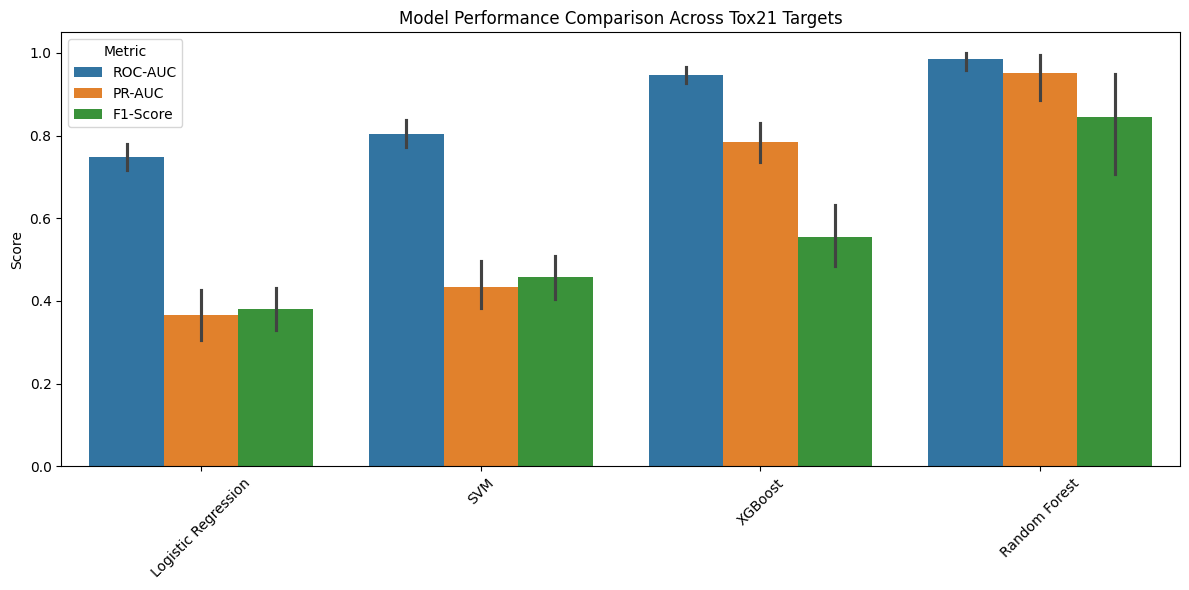

In [11]:
# Visualize and Save Results

results_df = pd.DataFrame(all_results)
results_df.to_csv("tox21_model_comparison_results.csv", index=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=results_df.melt(id_vars=["Target", "Model"]), x="Model", y="value", hue="variable")
plt.title("Model Performance Comparison Across Tox21 Targets")
plt.ylabel("Score")
plt.xlabel("")
plt.legend(title="Metric")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Summary of Model Performance on the Tox21 Dataset
We evaluated four machine learning models - Logistic Regression, Support Vector Machine (SVM), XGBoost, and Random Forest - across all 12 Tox21 toxicity prediction tasks. Performance was measured using ROC-AUC, PR-AUC, and F1-score on a stratified test split (20%).

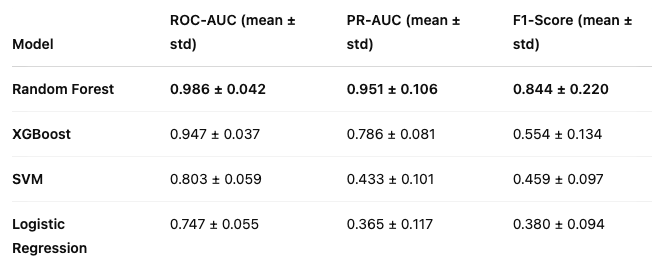

## 🔍 Key Observations

* `Random Forest` achieved the highest scores across all metrics, demonstrating strong generalization and robust handling of imbalanced classes.

* `XGBoost` performed slightly below Random Forest but remained competitive, particularly in terms of ROC-AUC.

* `SVM` showed moderate performance, outperforming Logistic Regression on most metrics but trailing behind ensemble models

* `Logistic Regression`, while fast and interpretable, consistently underperformed in PR-AUC and F1-score, indicating limited utility in this multi-target toxicology context.

## 📌 Why We Used a Train/Test Split Instead of Cross-Validation

In this study, we opted for a train/test split approach instead of k-fold cross-validation for the final model evaluation. This decision is based on the following rationale:

1. Cross-Validation was already performed during tuning
All models were previously optimized using 5-fold cross-validation through RandomizedSearchCV. This step provided robust estimates of performance during training and ensured optimal hyperparameter selection.

2. Consistent Evaluation Across Models
By using a single stratified train/test split, we ensured that all models — Logistic Regression, SVM, XGBoost, and Random Forest — were evaluated on the exact same test set. This enables a fair and direct comparison of their generalization capabilities on unseen data.

3. Final Performance Estimation
The primary goal at this stage was to assess real-world, out-of-sample performance. Train/test split provides a clearer picture of how each model would perform in a production or deployment setting.

4. Computational Efficiency
Given that we are comparing 4 models across 12 targets (48 total evaluations), applying cross-validation again would introduce unnecessary computational overhead without significantly improving evaluation reliability.

✅ Conclusion
The use of a stratified train/test split, following prior cross-validation for tuning, strikes a practical and statistically sound balance between robustness and efficiency. It provides a consistent and reproducible basis for comparing final model performance across all Tox21 targets.